### Create pairwise alignments of the BGC.

#### Input: list of genbank files (output of antismash)

#### Work:
- Load the called BGCs
- for each pair (could be a little smarter about this).
- perform alignment using Bio.pairwise
- calculate the identity
- create long format df
- present as heatmap.

#### Output: 
- heatmap of identity between the bgcs.
- Incl. nuc-seq length.

In [23]:
import os
import re
import itertools
from Bio import SeqIO, pairwise2
import pandas as pd
from typing import List

## Grab meta from antismash genbank files.

In [19]:
antismashdir = "../data/simulated_data/antismash/input_genomes"
gbk_files = [x for x in os.listdir(antismashdir) if x.endswith(".gbk") and x != "combined.gbk"]


### get seqlength for input files.
seq_annotation = {}
for file in gbk_files:
    seqname = file[:-4]
    file_fp = os.path.join(antismashdir, file)
    
    record = next(SeqIO.parse(file_fp, "genbank")) #assume 1 record per file.
    seq = record.seq.__str__()
    seq_len = len(record.seq)
    #grab predicted product.
    for feat in record.features:
        if feat.type == "protocluster":
            assigned = feat.qualifiers["product"]
            break
    seq_annotation[seqname] = {
        "fp": file_fp,
        "seq": seq,
        "seq_len": seq_len,
        "assigned_type": assigned
    }

In [22]:
def gbk_files_to_fasta(file_paths: List[str], output_file = "data/simulated_data/quantification/input_genomes_gbc.fa"):
    out_fh = open(output_file, "w")
    try:
        for fp in file_paths:
            name = os.path.basename(fp)
            records = SeqIO.parse(fp, "genbank")
            for record in records:
                for feat in record.features:
                    if feat.type == "protocluster":
                        assigned = feat.qualifiers["product"]
                        break
                fasta_entry=f">{name} {assigned} {record.description}\n{record.seq}\n"
    finally:
        out_fh.close()
        
    
    

NameError: name 'List' is not defined

In [20]:
seq_annotation

{'NC_014328.1.region004': {'fp': '../data/simulated_data/antismash/input_genomes/NC_014328.1.region004.gbk',
  'seq': 'ATAAGATATATGATTGGAATTTGTCTTTGTCCGATGGCATTGACTACAATACATCAGTTGACAAGTTATACAGGGAAGGTACTGGAAAGTGTGTCAATCCAAATAAAATATTTTTACTTGCTCATTGTGACGGTCAAAATAAAAACACCTGTGTGGTACTCTCTAAAATAATAAAACACTACAAAGAATTGGGATATGAATTCAAAGCAATTACAGAAAACACCCCTGAATATCACTTTAGAGTGAAGAGATAGTGAATTATACATTAAAAAAAGCTGCCAGGAAGTCAACTATTAGTTAACTTTCCAGCAACTTTTTTTCAACTTGTTACACAACGAGTAAAATAATTTTTTATTATTGCTGTCCAAAGCTTCATCTATCAAAATATACAAAATTTCAGTATACAATTTTCTTTTATCCAGACTAGTTATAGGGTTCATAGTAGGATTTTTATAAAGATCAAAAGAGTTGTCCAAATTTTCCCTGTGGACTTTCTTTAAAATCCATATATAATATGCTAGTTCTTCTTTTGATATGGTAAAAAACAATCTATTACAGTTATTTGTTGAAGATATCTTTATCATATCACTCTGCAAGTAAGTCAATTCCATTTCTCCAAAATTGCGTACTTTAAACTTACTGCTTTTAAAACTAGAACTTTTAAATTCACTTAAAAATTCTATATACCTTAAAAAATCTTTTTCTCCAAGTTTAAAATCATTTAGTACAGTATTAAAGCCGCACCTTTTTTGGAAAGAAATTTTATAATTGCTGCATCCTCCTGCATTGCTCACATTAGAAATAAAAATGCTATCTACAAATTTGTCCATTGCACGTTTTGGTATTAGCTTTATTCCATATTCAAAGTCCCCGTTTTTATG

In [13]:
gbkfile = "/mnt/computerome/home/projects/dtu_00009/people/henspi/git/AntibioticaScreening/project/data/simulated_data/antismash/input_genomes/NZ_LT906445.1.region001.gbk"
record = SeqIO.parse(gbkfile, "genbank")

In [14]:
records = list(record)

In [15]:
records

[SeqRecord(seq=Seq('CTAGTGTTGAAGGTAATATTGAAGTATCTGATGAAGATAAACAATATAAATGCC...TCT'), id='NZ_LT906445.1', name='NZ_LT906445.1', description='NZ_LT906445.1 Veillonella parvula strain NCTC11810 chromosome 1, complete sequence', dbxrefs=[])]

In [16]:
r = records[0]

In [17]:
len(r.seq)

21720

### Grab pairwise alignments

In [3]:
outdir = "../data/simulated_data/input_genomes/antismash/pw_align"
output_fhs = [os.path.join(outdir, f) for f in os.listdir(outdir)]

In [4]:
outdir = "../data/simulated_data/input_genomes/antismash/pw_align"
output_fhs = [os.path.join(outdir, f) for f in os.listdir(outdir)]

results = []
for fn in output_fhs:
    for line in open(fn, "r"):
        if line.startswith("#    -asequence"):
            seq1 = line.strip().rsplit("/",1)[1][:-4]
            continue
        elif line.startswith("#    -bsequence"):
            seq2 = line.strip().rsplit("/",1)[1][:-4]
            continue
        elif line.startswith("# Identity:"):
            reg_res = re.search(r"\((.+)%\)", line)
            if reg_res:
                iden = float(reg_res.group(1))
            break
    results.append((seq1, seq2, iden))

df = pd.DataFrame(columns = ["seq1","seq2","iden"], data=results) 
df

,seq1,seq2,iden
0,NZ_CP053893.1.region006,NC_014328.1.region001,46.5
1,NZ_CP053893.1.region005,NC_014328.1.region001,19.2
2,NC_014328.1.region005,NZ_LT906470.1.region002,38.5
3,NZ_LT906470.1.region001,NZ_CP053893.1.region004,40.6
4,NZ_CP053893.1.region005,NC_014328.1.region003,22.8
...,...,...,...
115,NZ_CP053893.1.region001,NZ_CP053893.1.region005,22.3
116,NZ_CP053893.1.region003,NC_014328.1.region005,43.3
117,NZ_CP053893.1.region002,NZ_LT906470.1.region003,42.8
118,NZ_LT906470.1.region001,NC_014328.1.region003,42.0


In [5]:
df_combined = pd.concat([
    pd.DataFrame(columns = ["seq1","seq2","iden"], data=results),
    pd.DataFrame(columns = ["seq2","seq1","iden"], data=results) 
]) # duplicates to go from triangle to full pw matrix

### Add metadata to pw iden%

In [7]:
df_meta = df_combined.assign(
    seq1_type = [seq_annotation[x]["assigned_type"] for x in df_combined.seq1],
    seq2_type = [seq_annotation[x]["assigned_type"] for x in df_combined.seq2],
    seq1_len  = [seq_annotation[x]["seq_len"] for x in df_combined.seq1],
    seq2_len  = [seq_annotation[x]["seq_len"] for x in df_combined.seq2]
)
df_meta

,seq1,seq2,iden,seq1_type,seq2_type,seq1_len,seq2_len
0,NZ_CP053893.1.region006,NC_014328.1.region001,46.5,[cyclic-lactone-autoinducer],[cyclic-lactone-autoinducer],20760,18152
1,NZ_CP053893.1.region005,NC_014328.1.region001,19.2,[cyclic-lactone-autoinducer],[cyclic-lactone-autoinducer],66040,18152
2,NC_014328.1.region005,NZ_LT906470.1.region002,38.5,[ranthipeptide],[betalactone],21591,32264
3,NZ_LT906470.1.region001,NZ_CP053893.1.region004,40.6,[betalactone],[cyclic-lactone-autoinducer],26333,19598
4,NZ_CP053893.1.region005,NC_014328.1.region003,22.8,[cyclic-lactone-autoinducer],[cyclic-lactone-autoinducer],66040,20752
...,...,...,...,...,...,...,...
115,NZ_CP053893.1.region005,NZ_CP053893.1.region001,22.3,[cyclic-lactone-autoinducer],[ranthipeptide],66040,21561
116,NC_014328.1.region005,NZ_CP053893.1.region003,43.3,[ranthipeptide],[cyclic-lactone-autoinducer],21591,20394
117,NZ_LT906470.1.region003,NZ_CP053893.1.region002,42.8,[ranthipeptide],[cyclic-lactone-autoinducer],21775,19866
118,NC_014328.1.region003,NZ_LT906470.1.region001,42.0,[cyclic-lactone-autoinducer],[betalactone],20752,26333


In [8]:
# get value matrix:
df_wide = df_combined.pivot_table(index="seq1", columns="seq2", values="iden")
x_ticks = df_wide.columns
y_ticks = df_wide.index
values = df_wide.values

In [9]:
import numpy as np
x_ticks_expanded = []
y_ticks_expanded = []
test = 0
for x, y in zip(x_ticks, y_ticks):
    genome_x, region_x = x.rsplit(".",1)
    genome_y, region_y = y.rsplit(".",1)
    type_x = "; ".join(seq_annotation[x]["assigned_type"]) + "_Reg"+ region_x[-3:] + f"_{seq_annotation[y]['seq_len']/1000:.1f}kb"
    type_y = "; ".join(seq_annotation[y]["assigned_type"]) + "_Reg"+ region_y[-3:] + f"_{seq_annotation[y]['seq_len']/1000:.1f}kb"
    x_ticks_expanded.append([genome_x, type_x])
    y_ticks_expanded.append([genome_y, type_y])
    test += 1

x_ticks_expanded = np.array(x_ticks_expanded).T
y_ticks_expanded = np.array(y_ticks_expanded).T 

In [31]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
    z=values,
    x=x_ticks_expanded,
    y=y_ticks_expanded,
    colorscale="Viridis",
    colorbar=dict(title='Seq identity (%)')
))

fig.update_layout(
    height=850
)
fig.update_xaxes(tickangle=90, ticklabeloverflow="allow")
fig.show()
fig.write_image(f"/mnt/c/Users/Henrik/Desktop/heatmap.png")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [29]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.0 MB/s eta 0:00:00m eta 0:00:010:00:01


In [26]:
import time
int(time.time())

1662464915

In [12]:
fig.__dict__

{'_validate': True,
 '_grid_str': None,
 '_grid_ref': None,
 '_data_validator': <plotly.validators._data.DataValidator at 0x7f5de6522a40>,
 '_data_objs': [Heatmap({
      'colorbar': {'title': {'text': 'Seq identity (%)'}},
      'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                     [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                     '#31688e'], [0.4444444444444444, '#26828e'],
                     [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                     '#35b779'], [0.7777777777777778, '#6ece58'],
                     [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
      'x': array([['NC_014328.1', 'NC_014328.1', 'NC_014328.1', 'NC_014328.1',
                   'NC_014328.1', 'NZ_CP020566.1', 'NZ_CP053893.1', 'NZ_CP053893.1',
                   'NZ_CP053893.1', 'NZ_CP053893.1', 'NZ_CP053893.1', 'NZ_CP053893.1',
                   'NZ_LT906445.1', 'NZ_LT906470.1', 'NZ_LT906470.1', 'NZ_LT906470.1'],
          

In [ ]:
df_wide = df_combined.pivot_table(index="seq1", columns="seq2", values="iden")

<AxesSubplot:xlabel='seq2', ylabel='seq1'>

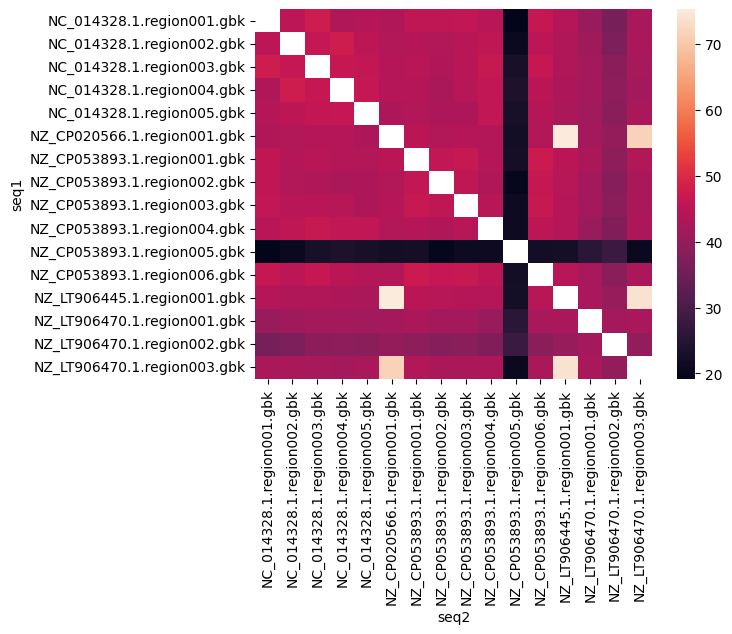

In [106]:
sns.heatmap(df_wide)

In [52]:
df_meta.query("iden>60")

,seq1,seq2,iden,seq1_type,seq2_type,seq1_len,seq2_len
56,NZ_LT906470.1.region003,NZ_CP020566.1.region001,71.6,[ranthipeptide],[ranthipeptide],21775,21721
80,NZ_LT906470.1.region003,NZ_LT906445.1.region001,73.8,[ranthipeptide],[ranthipeptide],21775,21720
107,NZ_LT906445.1.region001,NZ_CP020566.1.region001,75.3,[ranthipeptide],[ranthipeptide],21720,21721
56,NZ_CP020566.1.region001,NZ_LT906470.1.region003,71.6,[ranthipeptide],[ranthipeptide],21721,21775
80,NZ_LT906445.1.region001,NZ_LT906470.1.region003,73.8,[ranthipeptide],[ranthipeptide],21720,21775
107,NZ_CP020566.1.region001,NZ_LT906445.1.region001,75.3,[ranthipeptide],[ranthipeptide],21721,21720


<AxesSubplot:xlabel='feature', ylabel='people'>

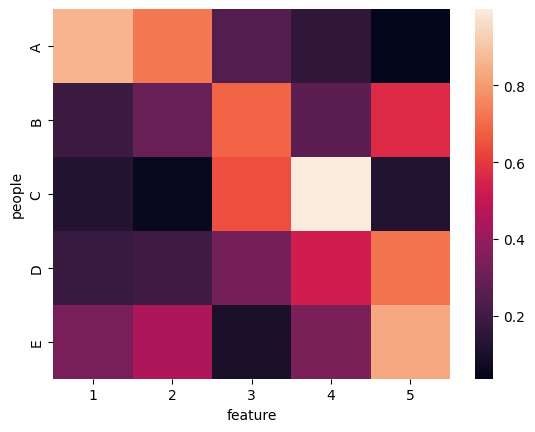

In [61]:
import seaborn as sns
import pandas as pd
import numpy as np
 
# Create long format
people = np.repeat(("A","B","C","D","E"),5)
feature = list(range(1,6))*5
value = np.random.random(25)
df = pd.DataFrame({'feature': feature, 'people': people, 'value': value })

# Turn long format into a wide format
df_wide = df.pivot_table( index='people', columns='feature', values='value')

# plot it
sns.heatmap(df_wide)

In [9]:
antismashdir = "/mnt/computerome/home/projects/dtu_00009/people/henspi/git/AntibioticaScreening/project/data/simulated_data/input_genomes/antismash"
gbk_files = [x for x in os.listdir(antismashdir) if x.endswith(".gbk") and x != "combined.gbk"]
gbk_files

['NC_014328.1.region004.gbk',
 'NZ_CP053893.1.region001.gbk',
 'NZ_LT906470.1.region001.gbk',
 'NZ_CP053893.1.region004.gbk',
 'NZ_CP053893.1.region003.gbk',
 'NZ_CP053893.1.region002.gbk',
 'NZ_CP053893.1.region005.gbk',
 'NC_014328.1.region003.gbk',
 'NZ_CP053893.1.region006.gbk',
 'NC_014328.1.region001.gbk',
 'NC_014328.1.region005.gbk',
 'NZ_LT906470.1.region002.gbk',
 'NZ_LT906470.1.region003.gbk',
 'NC_014328.1.region002.gbk',
 'NZ_LT906445.1.region001.gbk',
 'NZ_CP020566.1.region001.gbk']

In [10]:
#seq1 to seq2(s)
[(gbk_files[i], gbk_files[i+1::]) for i in range(len(gbk_files)-1)]

[('NC_014328.1.region004.gbk',
  ['NZ_CP053893.1.region001.gbk',
   'NZ_LT906470.1.region001.gbk',
   'NZ_CP053893.1.region004.gbk',
   'NZ_CP053893.1.region003.gbk',
   'NZ_CP053893.1.region002.gbk',
   'NZ_CP053893.1.region005.gbk',
   'NC_014328.1.region003.gbk',
   'NZ_CP053893.1.region006.gbk',
   'NC_014328.1.region001.gbk',
   'NC_014328.1.region005.gbk',
   'NZ_LT906470.1.region002.gbk',
   'NZ_LT906470.1.region003.gbk',
   'NC_014328.1.region002.gbk',
   'NZ_LT906445.1.region001.gbk',
   'NZ_CP020566.1.region001.gbk']),
 ('NZ_CP053893.1.region001.gbk',
  ['NZ_LT906470.1.region001.gbk',
   'NZ_CP053893.1.region004.gbk',
   'NZ_CP053893.1.region003.gbk',
   'NZ_CP053893.1.region002.gbk',
   'NZ_CP053893.1.region005.gbk',
   'NC_014328.1.region003.gbk',
   'NZ_CP053893.1.region006.gbk',
   'NC_014328.1.region001.gbk',
   'NC_014328.1.region005.gbk',
   'NZ_LT906470.1.region002.gbk',
   'NZ_LT906470.1.region003.gbk',
   'NC_014328.1.region002.gbk',
   'NZ_LT906445.1.region001.gbk'

In [13]:
# Extract fasta sequence:
regex_name_extract = re.compile(r"^(.+)\.(r.+).gbk$")
gbk_dict = dict()
for filename in gbk_files:
    regex_res = regex_name_extract.search(filename)
    iden = regex_res.group(1)
    region = regex_res.group(2)
    
    up_dict = gbk_dict.get(iden, dict())
    up_dict.update({
        region: "fasta_placeholder"
    })
    gbk_dict[iden] = up_dict
    

In [103]:
# Extract fasta sequence:
regex_name_extract = re.compile(r"^(.+)\.(r.+).gbk$")
gbk_dict = dict()
for filename in gbk_files:
    name = filename[:-4]
    file_fp = os.path.join(antismashdir, filename)
    record = next(SeqIO.parse(file_fp, "genbank")) #assume 1 record per file.
    
    seq = record.seq
    length = len(seq)
    gbc_type = []
    for feature in record.features:
        if feature.type == "protocluster":
            gbc_type.extend(feature.qualifiers["product"])
    gbk_dict[name] = {"seq": seq, "lenght": length, "type": gbc_type}
gbk_dict

{'NC_014328.1.region001': {'seq': Seq('TTGATAAAAGATTATTACAGTAGTAAACTTAATTTGAAATATACAGCATCTTTA...TAA'),
  'lenght': 21775,
  'type': ['cyclic-lactone-autoinducer']},
 'NC_014328.1.region002': {'seq': Seq('ATGAAAAATATCACACTACCGTCACCACATAAAATTCTAAATATCATACATGAA...CAT'),
  'lenght': 21775,
  'type': ['cyclic-lactone-autoinducer']},
 'NC_014328.1.region003': {'seq': Seq('TTAATCGTCTTTATCAATTAATACTAATGGTGCTAAATATTTTTCTGCTGCTGC...TAG'),
  'lenght': 21775,
  'type': ['cyclic-lactone-autoinducer']},
 'NC_014328.1.region004': {'seq': Seq('ATAAGATATATGATTGGAATTTGTCTTTGTCCGATGGCATTGACTACAATACAT...ATA'),
  'lenght': 21775,
  'type': ['cyclic-lactone-autoinducer']},
 'NC_014328.1.region005': {'seq': Seq('TACTATTTCTTTACAGCTTTCCACTTTACAATCCAATATCCTCATAGGATTTTT...AAT'),
  'lenght': 21775,
  'type': ['ranthipeptide']},
 'NZ_CP020566.1.region001': {'seq': Seq('CCGTACCATTTCGAATCAAAATGCAAGACGGCCTATGGATGCCAATCAAGTAAA...GCA'),
  'lenght': 21775,
  'type': ['ranthipeptide']},
 'NZ_CP053893.1.region001': {'seq'

In [104]:
choices = list(gbk_dict.keys())
combinations = []
for i in range(len(choices)-1):
    for partner in choices[i+1::]:
        combinations.append((choices[i], partner))
def perc_identity(aln):
    iden = 0
    for seqa_i, seqb_i in zip(aln[0], aln[1]):
        print(seqa_i, seqb_i)
        if seqa_i=="-" or seqb_i =="-":
            continue
        if seqa_i == seqb_i:
            iden += 1
    return 100*(iden/len(aln[0]))

In [ ]:
alignment = []
for i in range(len(combinations[0:2])):
    comb_in = combinations[i]
    print(comb_in)
    
    #
    seq1 = gbk_dict[comb_in[0]]["seq"]
    seq2 = gbk_dict[comb_in[1]]["seq"]
    al = pairwise2.align.globalxx(seq1, seq2)
    pct = np.mean([perc_identity(x) for x in al]) #if multiple align with equal score average the pct.
    
    

(1, 2, 3)

In [30]:
a = list(SeqIO.parse(file_fp, "genbank"))

In [33]:
a
r=a[0]

In [39]:
for feature in r.features:
    if feature.type == "protocluster":
        out = feature

In [46]:
out.qualifiers["product"]

['ranthipeptide']

In [26]:
gbk_dict

{'NC_014328.1.region001': {'fasta': Seq('TTGATAAAAGATTATTACAGTAGTAAACTTAATTTGAAATATACAGCATCTTTA...TAA'),
  'lenght': 18152},
 'NC_014328.1.region002': {'fasta': Seq('ATGAAAAATATCACACTACCGTCACCACATAAAATTCTAAATATCATACATGAA...CAT'),
  'lenght': 19041},
 'NC_014328.1.region003': {'fasta': Seq('TTAATCGTCTTTATCAATTAATACTAATGGTGCTAAATATTTTTCTGCTGCTGC...TAG'),
  'lenght': 20752},
 'NC_014328.1.region004': {'fasta': Seq('ATAAGATATATGATTGGAATTTGTCTTTGTCCGATGGCATTGACTACAATACAT...ATA'),
  'lenght': 22109},
 'NC_014328.1.region005': {'fasta': Seq('TACTATTTCTTTACAGCTTTCCACTTTACAATCCAATATCCTCATAGGATTTTT...AAT'),
  'lenght': 21591},
 'NZ_CP020566.1.region001': {'fasta': Seq('CCGTACCATTTCGAATCAAAATGCAAGACGGCCTATGGATGCCAATCAAGTAAA...GCA'),
  'lenght': 21721},
 'NZ_CP053893.1.region001': {'fasta': Seq('TTACGAATGGACAAGATAATGTGTTAAAAATTAGCATATATAAAGGGGTTCTGT...TTA'),
  'lenght': 21561},
 'NZ_CP053893.1.region002': {'fasta': Seq('ATGGATCAATTAAAATCAGAAAATCAAAACTTATCAAGAGGACTAAAAAATCGT...TAA'),
  'lenght': 19